In [2]:
import sys
import pandas as pd
import nibabel as nib
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [3]:
subjectDir = str('/media/corey/4TB-WDBlue/data-thesis/DTI/merged_data/')
DirExtName = str('/4o/averageFAs/')
FA_filenames = np.loadtxt('/media/corey/4TB-WDBlue/data-thesis/DTI/FA_fileList.txt',dtype=str)
#Load subjectlist of interest, store IDs as integers
sub_list = np.loadtxt('/home/corey/thesis-EP/EP_scripts/diagnostics/Logs/GoodSubs_28April23.txt',dtype=str)
#Store subject names as a list with a standard suffix if provided
sub_names = sub_list

subjectInfo = pd.read_csv(open('/media/corey/4TB-WDBlue/data-thesis/subject_info.csv'),delim_whitespace=True,usecols=(4,11))

In [4]:
control_FA = []
nonaff_FA = []
aff_FA = []
n_control = 0
n_aff = 0
n_nonaff = 0
for n in sub_names:
    path_to_data = subjectDir + n + DirExtName
    phen = subjectInfo.loc[subjectInfo['src_subject_id'] == n]
    pdesc = phen['phenotype_description'].values[0]
    for r in FA_filenames:
        fa_filename = path_to_data + r
        fa_file = nib.load(fa_filename)
        fa_data = fa_file.get_fdata()
        FA_val = np.max(fa_data)
        if pdesc == 'In,good,health':
            control_FA.append([FA_val, r])
        if pdesc == 'Non-affective,psychosis':
            nonaff_FA.append([FA_val, r])
        if pdesc == 'Affective,psychosis':
            aff_FA.append([FA_val, r])
    if pdesc == 'In,good,health':
        n_control += 1
    if pdesc == 'Non-affective,psychosis':
        n_nonaff +=1
    if pdesc == 'Affective,psychosis':
        n_aff += 1

In [5]:
c_regionwise_struct = []
n_rw_struct = []
a_rw_struct = []

all_FAs_c = []
mean_FAs_c = []
stdv_FA_c = []

all_FAs_n = []
mean_FAs_n = []
stdv_FA_n = []

all_FAs_a = []
mean_FAs_a = []
stdv_FA_a = []

curr_region = 0
for r in FA_filenames:
    regional_c = [tuple for tuple in control_FA if any(r == i for i in tuple)] #Sort data by region
    reg_n = [tuple for tuple in nonaff_FA if any(r == i for i in tuple)]
    reg_a = [tuple for tuple in aff_FA if any(r == i for i in tuple)]

    c_regionwise_struct.append(regional_c) #Create list of tuples for each group
    n_rw_struct.append(reg_n)
    a_rw_struct.append(reg_a)

    fullc = [list(zip(*c_regionwise_struct[curr_region]))[0],r]
    meanc = [np.mean(list(zip(*c_regionwise_struct[curr_region]))[0]),r]
    stdvc = [np.std(list(zip(*c_regionwise_struct[curr_region]))[0]),r]
    fulln = [list(zip(*n_rw_struct[curr_region]))[0],r]
    meann = [np.mean(list(zip(*n_rw_struct[curr_region]))[0]),r]
    stdvn = [np.std(list(zip(*n_rw_struct[curr_region]))[0]),r]
    fulla = [list(zip(*a_rw_struct[curr_region]))[0],r]
    meana = [np.mean(list(zip(*a_rw_struct[curr_region]))[0]),r]
    stdva = [np.std(list(zip(*a_rw_struct[curr_region]))[0]),r]

    all_FAs_c.append(fullc) #Store all, mean, and standard deviation values in list including region labels
    mean_FAs_c.append(meanc)
    stdv_FA_c.append(stdvc)

    all_FAs_n.append(fulln)
    mean_FAs_n.append(meann)
    stdv_FA_n.append(stdvn)

    all_FAs_a.append(fulla)
    mean_FAs_a.append(meana)
    stdv_FA_a.append(stdva)

    curr_region += 1 #Increase index counter

[[0.13890411227092808, 'cerb_10.nii'], [0.16206029478646602, 'cerb_5.nii'], [0.15375736436265672, 'cerb_7.nii'], [0.13818047666993738, 'cerb_8.nii'], [0.2766685150943529, 'jhu_10.nii'], [0.27699050226422345, 'jhu_11.nii'], [0.2988740977936958, 'jhu_12.nii'], [0.2583262669369187, 'jhu_13.nii'], [0.2657922783284359, 'jhu_14.nii'], [0.2755468810671836, 'jhu_15.nii'], [0.282171132929511, 'jhu_16.nii'], [0.22730082207321634, 'jhu_17.nii'], [0.1990480823324418, 'jhu_18.nii'], [0.28095235228008364, 'jhu_19.nii'], [0.3076850107033618, 'jhu_1.nii'], [0.3591081379648873, 'jhu_20.nii'], [0.28655099916463966, 'jhu_2.nii'], [0.382136805586335, 'jhu_3.nii'], [0.38228110076879307, 'jhu_4.nii'], [0.3081856777592481, 'jhu_5.nii'], [0.30928559077246026, 'jhu_6.nii'], [0.18779189418152475, 'jhu_7.nii'], [0.19990807547366723, 'jhu_8.nii'], [0.2884841600752966, 'jhu_9.nii'], [0.4832340568363152, 'thal_1.nii'], [0.431424252894418, 'thal_2.nii'], [0.31734064165006565, 'thal_3.nii'], [0.33399148954919594, 'th

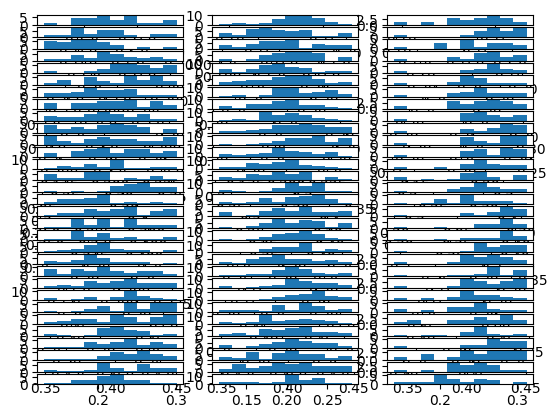

In [10]:
print(mean_FAs_c)
print(mean_FAs_n)
print(mean_FAs_a)
print(stdv_FA_c)
print(stdv_FA_n)
print(stdv_FA_a)
print(n_control, n_nonaff, n_aff)
#Plot histograms of average FA for each tract for each group (visually inspect if normally distributed) for groups of size n < 30, peform 
#Shapiro-Wilk test for normality
print(all_FAs_c[0][0])
curr_region = 0
f,ax = plt.subplots(31,3)
#Overall plot (should be reduced into individual rows for readability) - axes should be trimmed, colors per tract should be implemented
for x in enumerate(FA_filenames):
    print(x)
    h, bins, _ = ax[x[0],0].hist(all_FAs_c[x[0]][0],label=x[1])
    h, bins, _ = ax[x[0],1].hist(all_FAs_n[x[0]][0],label=x[1])
    h, bins, _ = ax[x[0],2].hist(all_FAs_a[x[0]][0],label=x[1])

In [40]:
#Calculate mean and standard deviation for the FA values in each group and perform subsequent T-tests for differences in means with heterogenous variance
import scipy.stats as stats
Difference_C_N = []
Difference_C_A = []
Difference_N_A = []
difference_c_n_fs = []
difference_c_a_fs = []
difference_n_a_fs = []
x = enumerate(FA_filenames)
for r in x:
    test_c_n = stats.ttest_ind(all_FAs_c[r[0]][0],all_FAs_n[r[0]][0],equal_var=False)
    if test_c_n[1] <= 0.05:
        store_c_n = [test_c_n[0], test_c_n[1], r[1]]
        Difference_C_N.append(store_c_n)
    test_c_a = stats.ttest_ind(all_FAs_c[r[0]][0],all_FAs_a[r[0]][0],equal_var=False)
    #print(test_c_a)
    if test_c_a[1] <= 0.05:
        store_c_a = [test_c_a[0], test_c_a[1], r[1]]
        Difference_C_A.append(store_c_a)
    test_n_a = stats.ttest_ind(all_FAs_n[r[0]][0],all_FAs_a[r[0]][0],equal_var=False)
    #print(test_n_a)
    if test_n_a[1] <= 0.05:
        store_n_a = [test_n_a[0], test_n_a[1], r[1]]
        Difference_N_A.append(store_n_a)

    test_fs_c_n = stats.ttest_ind_from_stats(mean1=mean_FAs_c[r[0]][0],mean2=mean_FAs_n[r[0]][0],std1=stdv_FA_c[r[0]][0],std2=stdv_FA_n[r[0]][0],nobs1=n_control,nobs2=n_nonaff)
    if test_fs_c_n[1] <= 0.05:
        store_fs_c_n = [test_fs_c_n[0], test_fs_c_n[1], r[1]]
        difference_c_n_fs.append(store_fs_c_n)
    test_fs_c_a = stats.ttest_ind_from_stats(mean1=mean_FAs_c[r[0]][0],mean2=mean_FAs_a[r[0]][0],std1=stdv_FA_c[r[0]][0],std2=stdv_FA_a[r[0]][0],nobs1=n_control,nobs2=n_aff)
    if test_fs_c_a[1] <= 0.05:
        store_fs_c_a = [test_fs_c_a[0], test_fs_c_a[1], r[1]]
        difference_c_a_fs.append(store_fs_c_a)
    test_fs_n_a = stats.ttest_ind_from_stats(mean1=mean_FAs_n[r[0]][0],mean2=mean_FAs_a[r[0]][0],std1=stdv_FA_n[r[0]][0],std2=stdv_FA_a[r[0]][0],nobs1=n_nonaff,nobs2=n_aff)
    if test_fs_n_a[1] <= 0.05:
        store_fs_n_a = [test_fs_n_a[0], test_fs_n_a[1], r[1]]
        difference_n_a_fs.append(store_fs_n_a)
#Store significant results in lists
print(difference_c_n_fs)
print(difference_c_a_fs)
print(difference_n_a_fs)
print(Difference_C_N)
print(Difference_C_A)
print(Difference_N_A)


[[2.5126211537281113, 0.014290499847178317, 'jhu_13.nii'], [2.1556091371931463, 0.03455396500308766, 'jhu_8.nii'], [2.089582576751846, 0.04029085965101451, 'thal_1.nii']]
[]
[]
[[2.540673947064671, 0.01345914020745331, 'jhu_13.nii'], [2.2269868960553536, 0.029252868620822985, 'jhu_8.nii'], [2.0862100345305903, 0.041032122047747914, 'thal_1.nii']]
[]
[]


In [36]:
diff_med_c_n = []
x = enumerate(FA_filenames)
for r in x:
    med_test_c_n = stats.median_test(all_FAs_c[r[0]][0],all_FAs_n[r[0]][0])
    if med_test_c_n[1] <= 0.05:
        store_med_c_n = (med_test_c_n[0], med_test_c_n[1], r[1])
        diff_med_c_n.append(store_med_c_n)
print(diff_med_c_n)

[]


In [ ]:
#Bonferroni correction and store in new table

In [41]:
cFA = []
pFA = []
n_c = 0
n_p = 0
for n in sub_names:
    path_to_data = subjectDir + n + DirExtName
    phen = subjectInfo.loc[subjectInfo['src_subject_id'] == n]
    pdesc = phen['phenotype_description'].values[0]
    for r in FA_filenames:
        fa_filename = path_to_data + r
        fa_file = nib.load(fa_filename)
        fa_data = fa_file.get_fdata()
        FA_val = np.max(fa_data)
        if pdesc == 'In,good,health':
            cFA.append([FA_val, r])
        if pdesc == 'Non-affective,psychosis' or pdesc=='Affective,psychosis':
            pFA.append([FA_val, r])

    if pdesc == 'In,good,health':
        n_c += 1
    if pdesc == 'Non-affective,psychosis' or pdesc=='Affective,psychosis':
        n_p +=1

In [49]:
c_rw = []
p_rw = []

c_all = []
m_c = []
st_c = []

p_all = []
m_p = []
st_p = []
curr_region = 0 #Alternatively could use enumerate
for r in FA_filenames:
    r_c = [tuple for tuple in cFA if any(r == i for i in tuple)] #Sort data by region
    r_p = [tuple for tuple in pFA if any(r == i for i in tuple)]
    c_rw.append(r_c) #Create list of tuples for each group
    p_rw.append(r_p)

    fc = [list(zip(*c_rw[curr_region]))[0],r]
    av_c = [np.mean(list(zip(*c_rw[curr_region]))[0]),r]
    std_c = [np.std(list(zip(*c_rw[curr_region]))[0]),r]
    
    fp = [list(zip(*p_rw[curr_region]))[0],r]
    av_p = [np.mean(list(zip(*p_rw[curr_region]))[0]),r]
    std_p = [np.std(list(zip(*p_rw[curr_region]))[0]),r]

    c_all.append(fc) #Store all, mean, and standard deviation values in list including region labels
    m_c.append(av_c)
    st_c.append(std_c)

    p_all.append(fp)
    m_p.append(av_p)
    st_p.append(std_p)
    curr_region += 1 #Increase index counter
print(c_all)
print(p_all)

[[(0.1442173533800486, 0.13598155485457933, 0.163480184501849, 0.14519607006609273, 0.15297952092589645, 0.1576295886223667, 0.12157695686565063, 0.14961899863038247, 0.13510988385976347, 0.1305812729321078, 0.14838447776645475, 0.16454614163818318, 0.12620808693739502, 0.16850677126332225, 0.14763635194906352, 0.13103573005953076, 0.14143630587816247, 0.12789240180649344, 0.1390305888228218, 0.1240501055421518, 0.14142057534331515, 0.12144717843756832, 0.13178053355452166, 0.13649722338685438, 0.13498548970911856, 0.10607171781985923, 0.13308756227415072, 0.14645929025995108, 0.12137133876925998), 'cerb_10.nii'], [(0.16175072873885998, 0.16773141277612214, 0.1928976225136145, 0.1695494635723118, 0.16446617853701445, 0.18594729238669455, 0.14353469873002184, 0.16763445312705055, 0.16088381480173236, 0.16361781668065253, 0.15939564506229442, 0.18212040824622508, 0.15644585550546375, 0.1937550827917794, 0.16963785390176656, 0.1672807962297189, 0.17228094320718898, 0.1518402832909818, 0.1

In [50]:
import scipy.stats as stats
DelCP = []
x = enumerate(FA_filenames)
for r in x:
    test_c_p = stats.ttest_ind(c_all[r[0]][0],p_all[r[0]][0],equal_var=False)
    print(test_c_p)
    if test_c_p[1] <= 0.05:
        store_c_p = [test_c_p[0], test_c_p[1], r[1]]
        DelCP.append(store_c_p)
#Store significant results in lists
print(DelCP)

Ttest_indResult(statistic=0.5901287924446175, pvalue=0.5574120901347083)
Ttest_indResult(statistic=0.3121695547902057, pvalue=0.7558515189896082)
Ttest_indResult(statistic=0.13757893112120492, pvalue=0.8910377938018577)
Ttest_indResult(statistic=0.7145358510606727, pvalue=0.4779512493400675)
Ttest_indResult(statistic=1.4970705456086917, pvalue=0.1385698847103799)
Ttest_indResult(statistic=0.49987291406894135, pvalue=0.6188353722094246)
Ttest_indResult(statistic=1.5352670450346528, pvalue=0.1301378204074506)
Ttest_indResult(statistic=2.2883576406285537, pvalue=0.025433207612265817)
Ttest_indResult(statistic=0.9842461929951208, pvalue=0.328487807122139)
Ttest_indResult(statistic=1.8316568255949144, pvalue=0.0708483322423259)
Ttest_indResult(statistic=1.2534458992246207, pvalue=0.21383029095247444)
Ttest_indResult(statistic=1.5044563425298816, pvalue=0.13718496564585947)
Ttest_indResult(statistic=0.5386972324507683, pvalue=0.591972134912673)
Ttest_indResult(statistic=1.0985106673755807, p